In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Patch
import numpy as np
from enum import Enum
import importlib
import electricity_lib as ec_lib

importlib.reload(ec_lib)
pd.options.mode.chained_assignment = None  # default='warn'
# 設置微軟正黑體為全域字體
rcParams['font.family'] = 'Microsoft JhengHei'
battery_kwh = 261 * 4 * 0.95
battery_kw = 125 * 4 * 0.95

In [25]:
# 讀取 Excel 檔案
file_path = "meter_02293584018_data.xlsx"
# 設定合約類型與釋放類型
contract_type = ec_lib.ContractType.HIGH_PRESSURE_THREE_PHASE
release_type = ec_lib.ReleaseType.MAX
elec_type_dict = ec_lib.get_elec_type_dict(contract_type)
# 讀取充放電時間參數
release_hour_dict = ec_lib.get_release_hour_dict(contract_type,
                                                    release_type)
charge_hour_dict = ec_lib.get_charege_hour_dict(contract_type)

time_col = "時間"
usage_col = "用電總量"
default_drop_cols = ['儲冷尖峰', '儲冷半尖峰', '儲冷週六半尖峰', '儲冷離峰', '太陽光電']
columns_to_sum = ['尖峰', '半尖峰', '週六半尖峰', '離峰']

raw_data = pd.read_excel(file_path)
raw_data.drop(columns=default_drop_cols, inplace=True, errors='ignore')

# 將時間欄位轉換為日期時間格式
raw_data[time_col] = pd.to_datetime(raw_data[time_col])
raw_data[usage_col] = raw_data[columns_to_sum].apply(
    lambda row: row.dropna().unique()[0]
    if row.nunique() == 1 else row.mode().iloc[0],
    axis=1)
raw_data[usage_col] = raw_data[usage_col] * 0.25
raw_data = raw_data.drop(columns=columns_to_sum)

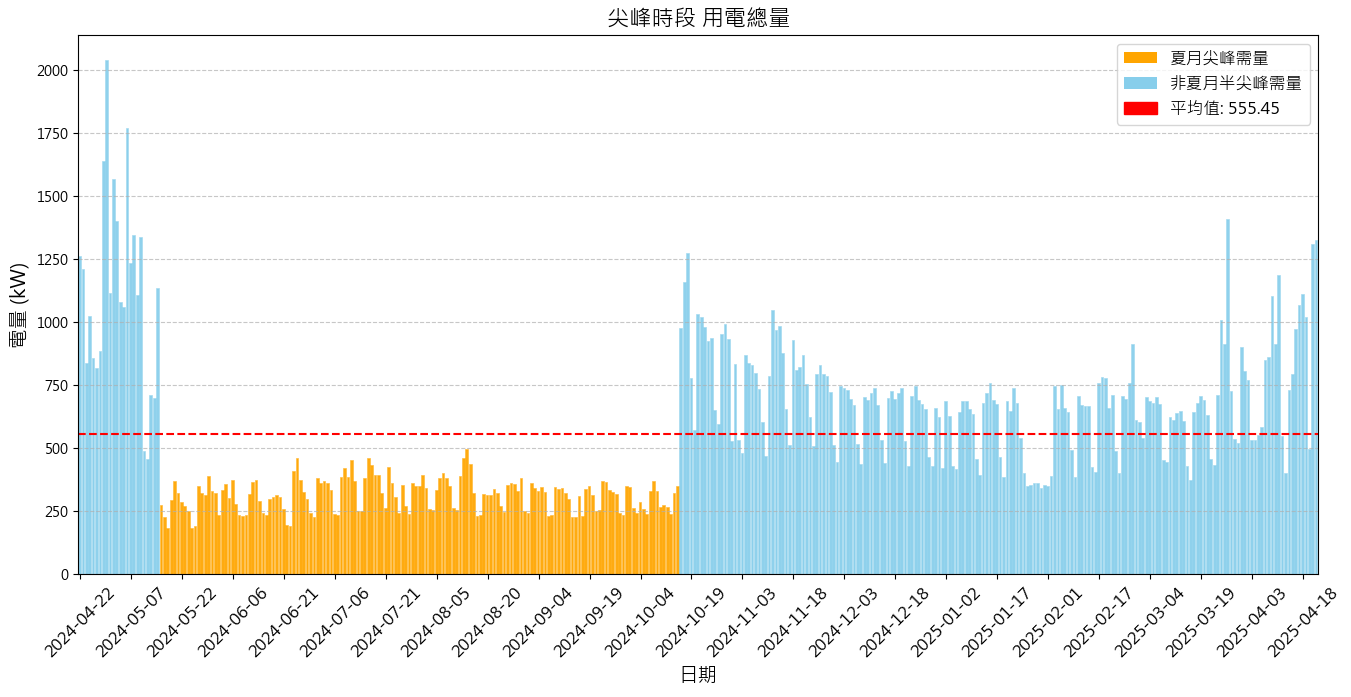

In [37]:
def in_peak_hour(date, elec_type_dict):
    """
    判斷是否在尖峰時段的函數
    :param date: 日期
    :param time: 時間
    :param elec_type_dict: 尖峰時段字典
    :return: 是否在尖峰時段
    """
    result = False
    peak_hour = []
    if ec_lib.is_summer(date):
        peak_hour = elec_type_dict.get(ec_lib.SeasonType.SUMMER).get(
            ec_lib.UsageType.PEAK)
    else:
        elec_hour_dict = elec_type_dict.get(ec_lib.SeasonType.NONSUMMER)
        if ec_lib.UsageType.PEAK in elec_hour_dict:
            peak_hour = elec_hour_dict.get(ec_lib.UsageType.PEAK)
        else:
            peak_hour = elec_hour_dict.get(ec_lib.UsageType.SEMI_PEAK)
    peak_hour = pd.to_datetime(peak_hour, format='%H:%M:%S').time
    date_time = date.time()
    # 判斷時間是否在尖峰時段
    for i in range(0,len(peak_hour),2):
        start_time = peak_hour[i]
        end_time = peak_hour[i+1]
        if start_time <= date_time <= end_time:
            result = True
            break
    return result


def get_peak_hour_usage(data, time_col, usage_col, elec_type_dict):
    """
    顯示尖峰時段用電總量的函數
    :param data: 數據集
    :param time_col: 時間欄位名稱
    :param usage_col: 用電總量欄位名稱
    """
    # 篩選需要的時間段和欄位
    filtered_data = data[data[time_col].apply(
        lambda x: in_peak_hour(x, elec_type_dict))]
    # 按日期統計用電總量
    return filtered_data.groupby(
        filtered_data[time_col].dt.date)[usage_col].sum()


daily_summary = get_peak_hour_usage(raw_data, time_col, usage_col,
                                    elec_type_dict)
average_power = daily_summary.mean()
# 設置顏色：夏季（6月16日到10月15日）為橘色，其他為天藍色
colors = [
    'orange' if (date.month > 5 or (date.month == 5 and date.day >= 16)) and
    (date.month < 10 or (date.month == 10 and date.day <= 15)) else 'skyblue'
    for date in daily_summary.index
]

# 繪製柱狀圖
daily_summary.plot(kind='bar',
                   figsize=(16, 7),
                   color=colors,
                   edgecolor=colors,
                   linewidth=1.2,
                   alpha=0.8)

# 設置平均線
plt.axhline(y=average_power, color='red', linestyle='--')

# 設置 X 軸的顯示間隔
x_labels = daily_summary.index
plt.xticks(range(0, len(x_labels), 15),
           x_labels[::15],
           rotation=45,
           fontsize=12)

# 圖表設置
plt.title('尖峰時段 用電總量', fontsize=16)
plt.xlabel('日期', fontsize=14)
plt.ylabel('電量 (kW)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # 日期旋轉以便於閱讀

legend_elements = [
    Patch(facecolor='orange', label='夏月尖峰需量'),
    Patch(facecolor='skyblue',
          label='非夏月半尖峰需量' if contract_type
          == ec_lib.ContractType.HIGH_PRESSURE_THREE_PHASE else '非夏月尖峰需量'),
    Patch(color='red', label=f'平均值: {average_power:.2f}')
]
plt.legend(handles=legend_elements, fontsize=12, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
plt.close('all')

In [ ]:
battery_kw_col = "電池放電功率"
battery_kwh_col = "電池容量"
usage_with_battery_col = "電池與用電量"

# 預處理時就增加欄位 確定這時間點狀態 & 預計充放電量


def cal_charge_power(date, charge_hour_dict, battery_kw):
    charge_hour_list = []
    if ec_lib.is_summer(date):
        charge_hour_list = charge_hour_dict.get(ec_lib.SeasonType.SUMMER)
    else:
        charge_hour_list = charge_hour_dict.get(
            ec_lib.SeasonType.NONSUMMER)
    charge_hour_list = pd.to_datetime(charge_hour_list, format='%H:%M:%S').time
    charge_power = 0.0
    for i in range(0, len(charge_hour_list), 2):
        start_time = charge_hour_list[i]
        end_time = charge_hour_list[i + 1]
        if start_time <= date.time() <= end_time:
            charge_power = battery_kw
            break
    return charge_power


def cal_release_power(date, release_hour_dict, release_type, battery_kwh, battery_kw):
    release_hour_list = []
    if ec_lib.is_summer(date):
        release_hour_list = release_hour_dict.get(ec_lib.SeasonType.SUMMER)
    else:
        release_hour_list = release_hour_dict.get(
            ec_lib.SeasonType.NONSUMMER)
    release_hour_list = pd.to_datetime(release_hour_list,
                                       format='%H:%M:%S').time
    release_power = 0.0
    for i in range(0, len(release_hour_list), 2):
        start_time = release_hour_list[i]
        end_time = release_hour_list[i + 1]
        if start_time <= date.time() <= end_time:
            if release_type == ec_lib.ReleaseType.MAX:
                release_power = battery_kw
            elif release_type == ec_lib.ReleaseType.AVERAGE:
                release_power = battery_kwh / \
                    ((end_time-start_time).seconds+1)/3600.0
            break
    return release_power


def process_battery_usage(row, release_hour_dict, charge_hour_dict):
    date_time = row[time_col]
    is_workday = ec_lib.is_workday(date_time)
    # if(is_workday):
    return 0.0, 0.0, 0.0


raw_data[[battery_kw_col, battery_kwh_col, usage_with_battery_col]
         ] = pd.DataFrame(raw_data.apply(lambda row: process_battery_usage(row, release_hour_dict, charge_hour_dict), axis=1).tolist(), index=raw_data.index)

                       時間   經常  用電總量  電池放電功率  電池容量  電池與用電量
0     2025-04-22 00:00:00  330  9.00     0.0   0.0     0.0
1     2025-04-22 00:15:00  330  7.00     0.0   0.0     0.0
2     2025-04-22 00:30:00  330  7.25     0.0   0.0     0.0
3     2025-04-22 00:45:00  330  7.25     0.0   0.0     0.0
4     2025-04-22 01:00:00  330  7.75     0.0   0.0     0.0
...                   ...  ...   ...     ...   ...     ...
35035 2024-04-22 22:45:00  400  9.00     0.0   0.0     0.0
35036 2024-04-22 23:00:00  400  9.00     0.0   0.0     0.0
35037 2024-04-22 23:15:00  400  9.00     0.0   0.0     0.0
35038 2024-04-22 23:30:00  400  9.00     0.0   0.0     0.0
35039 2024-04-22 23:45:00  400  9.00     0.0   0.0     0.0

[35040 rows x 6 columns]


In [ ]:
# 按日期統計用電總量
original_max_demand_power = lower_daily_summary[
    original_15_max_demand_col].max()
new_max_demand_power = lower_daily_summary[lower_15_max_demand_col].max()

# 設置顏色：夏季（6月16日到10月15日）為橘色，其他為天藍色

new_colors = [
    'lawngreen' if (date.month > 5 or (date.month == 5 and date.day >= 16)) and
    (date.month < 10 or (date.month == 10 and date.day <= 15)) else 'violet'
    for date in lower_daily_summary[date_col]
]
fig, ax = plt.subplots(figsize=(16, 7))

summer_start_index, summer_end_index = 0, 0
for i in range(len(lower_daily_summary[date_col])):
    date = lower_daily_summary[date_col][i]
    if date.month == 5 and date.day == 16:
        summer_start_index = i
    elif date.month == 10 and date.day == 15:
        summer_end_index = i

ax.fill_between(range(len(lower_daily_summary[date_col])),
                lower_daily_summary[original_15_max_demand_col].values,
                label="Daily Summary",
                color='skyblue',
                linewidth=1.2,
                alpha=0.8)
ax.fill_between(range(summer_start_index, summer_end_index),
                lower_daily_summary[original_15_max_demand_col].
                values[summer_start_index:summer_end_index],
                label="Daily Summary",
                color='orange',
                linewidth=1.2,
                alpha=0.8)

# 繪製第二個 DataFrame 的折線圖
ax.fill_between(range(len(lower_daily_summary[date_col])),
                lower_daily_summary[lower_15_max_demand_col].values,
                label="Lower Daily Summary",
                color='darkviolet',
                linewidth=1.2,
                alpha=0.8)

# 設置平均線
ax.axhline(y=original_max_demand_power, color='red', linestyle='--')
ax.axhline(y=new_max_demand_power, color='brown', linestyle='--')

# 設置 X 軸的顯示間隔
x_labels = lower_daily_summary[date_col]
tick_positions = range(0, len(x_labels), max(1, len(x_labels) // 15))  # 設置動態間隔
ax.set_xticks(tick_positions)
ax.set_xticklabels(x_labels[tick_positions], rotation=45, fontsize=12)
ax.set_xlim(left=0, right=len(x_labels))  # X 軸從 0 開始
ax.set_ylim(bottom=0)

# 圖表設置
plt.title('尖峰時段 15分鐘最高需量', fontsize=16)
plt.xlabel('日期', fontsize=14)
plt.ylabel('最高需量 (kW)', fontsize=14)

legend_elements = [
    Patch(facecolor='orange', label='(原)夏月尖峰需量'),
    Patch(facecolor='skyblue', label='(原)非夏月尖峰需量'),
    Patch(color='red', label=f'(原)尖峰最高需量: {original_max_demand_power:.2f}'),
    Patch(color='brown', label=f'新尖峰最高需量: {new_max_demand_power:.2f}')
]
plt.legend(handles=legend_elements, fontsize=12, loc='upper right')
plt.show()